<a href="https://colab.research.google.com/github/YasinnSoylu/Adversarial-Autoencoder-imagenoise-removal/blob/main/Denoising___Autoencoder__image__noise_removal_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2DTranspose


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


4422102/4422102 [==============================] - 0s 0us/step


Bu kod bloğunda, fashion_mnist.load_data() metodu kullanılarak Fashion-MNIST veri seti yüklenir. Veriler, eğitim ve test kümeleri olarak ayrılır.

x_train ve x_test verileri, astype() metodu kullanılarak önce float32 veri tipine dönüştürülür ve daha sonra 255 ile bölünerek piksel değerleri 0-1 aralığına ölçeklenir.

np.reshape() metodu kullanılarak, her bir veri örneği 28x28 piksel boyutlarında ve sadece tek bir kanalı olan (siyah-beyaz) bir görüntü olarak yeniden boyutlandırılır. Bu, daha sonra otokodlayıcı modelinde kullanılmak üzere verilerin şeklini değiştirir.

In [3]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


Bu kod bloğunda, gürültülü veriler oluşturulur. noise_factor değişkeni, gürültü faktörünü belirler. np.random.normal() metodu kullanılarak, normal dağılımdan rasgele sayılar oluşturulur. Bu rasgele sayılar, x_train ve x_test verilerine eklenerek gürültülü veriler oluşturulur.

np.clip() metodu kullanılarak, veriler belirtilen minimum ve maksimum değerler arasında kesilir. Burada, gürültülü veriler 0 ile 1 arasında olacak şekilde kesilir.

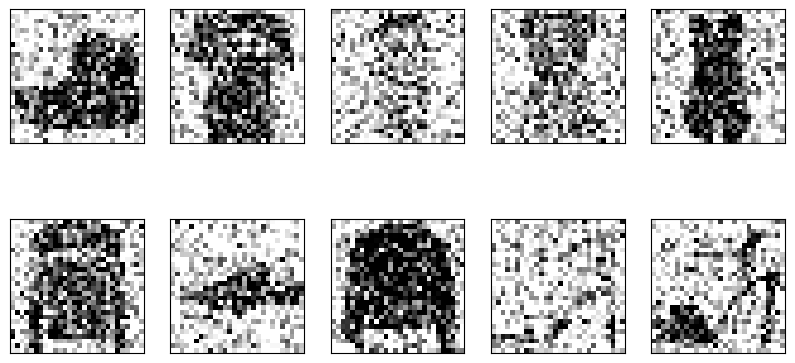

In [4]:
# Gürültü eklenmiş eğitim verisi
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

In [5]:
from tensorflow.keras.layers import Conv2DTranspose

input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


Bu kod bloğu, bir önceki modelin geliştirilmiş versiyonudur. İlk olarak, girdi boyutu (28x28x1) tanımlanır.

Daha sonra, iki adet 2 boyutlu (3,3) boyutlu Conv2D katmanı tanımlanır. İlk katmanda 32 adet filtre kullanılırken, ikincisinde 64 adet filtre kullanılır. Her iki katmanda da "relu" aktivasyon fonksiyonu kullanılır ve "same" dolgusu yapılır.

Ardından, iki adet 2 boyutlu (2,2) boyutlu MaxPooling2D katmanı tanımlanır. Bu katmanlar, boyutu yarıya indirilmiş görüntüler üretir.

Daha sonra, kodun önceki kısmında kodlanan verileri temsil etmek için bir "encoded" katman tanımlanır. Bu katman, iki adet 2 boyutlu Conv2D katmanından sonra oluşturulan boyutu yarıya indirilmiş verileri temsil eder.

Modelin geliştirilmiş kısmı, kodun önceki kısmından farklı olarak Conv2DTranspose katmanları içerir. Bu katmanlar, boyutu yarıya indirilmiş görüntülerin yeniden boyutlandırılarak orijinal boyutuna dönüştürülmesini sağlar. İlk Conv2DTranspose katmanı, boyutu yarıya indirilmiş ve Conv2D katmanında işlenmiş 64 özellik haritasını alır. Bu katman, boyutu iki katına çıkarmak için (2, 2) boyutlu bir stride kullanarak yeniden boyutlandırır. Daha sonra, bir adet 2 boyutlu (3,3) boyutlu Conv2D katmanı tanımlanır ve "relu" aktivasyon fonksiyonu kullanılır. Bu katman, yeniden boyutlandırılmış verileri işler.

İkinci Conv2DTranspose katmanı, boyutu yarıya indirilmiş ve önceki Conv2D katmanında işlenmiş 32 özellik haritasını alır. Bu katman da boyutu iki katına çıkarmak için (2, 2) boyutlu bir stride kullanarak yeniden boyutlandırır. Daha sonra, bir adet 2 boyutlu (3,3) boyutlu Conv2D katmanı tanımlanır ve "relu" aktivasyon fonksiyonu kullanılır. Bu katman, yeniden boyutlandırılmış verileri işler.

Son olarak, modelin gürültülü girdiler üzerinde kayıp değerlerini minimize etmek için "binary_crossentropy" kayıp fonksiyonu kullanılarak derlenir.

In [6]:
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=25,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))



Epoch 1/25
1875/1875 [==============================] - 23s 6ms/step - loss: 0.2993 - val_loss: 0.2886
Epoch 2/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2831 - val_loss: 0.2837
Epoch 3/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2806 - val_loss: 0.2821
Epoch 4/25
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2793 - val_loss: 0.2809
Epoch 5/25
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2785 - val_loss: 0.2805
Epoch 6/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2779 - val_loss: 0.2800
Epoch 7/25
1875/1875 [==============================] - 10s 6ms/step - loss: 0.2775 - val_loss: 0.2800
Epoch 8/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2772 - val_loss: 0.2794
Epoch 9/25
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2769 - val_loss: 0.2800
Epoch 10/25
1875/1875 [==============================] - 10s 5ms/step - l

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']


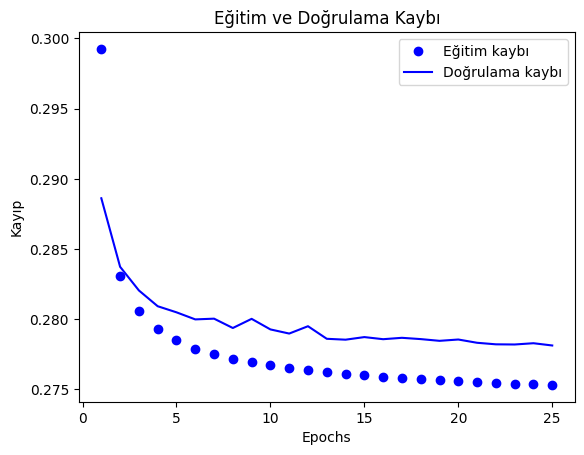

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Eğitim kaybı')
plt.plot(epochs, val_loss, 'b', label='Doğrulama kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Kayıp')
plt.legend()
plt.show()


313/313 [==============================] - 1s 2ms/step


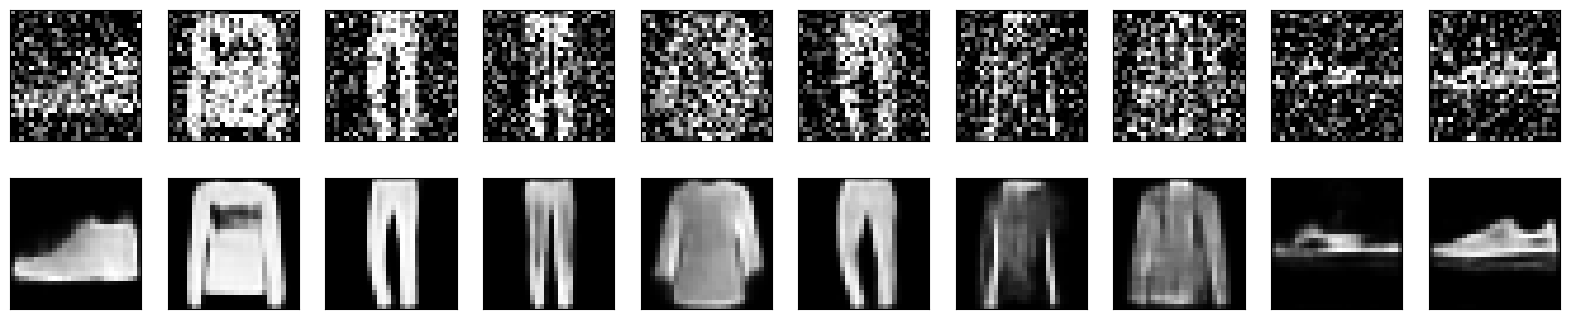

In [9]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Gürültülü görüntüleri göster
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Yeniden yapılandırılmış görüntüleri göster
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
